In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
main = '/content/drive/My Drive/Deep_Breath/'

diagnosis_df = pd.read_csv('/content/drive/My Drive/Deep_Breath/raw_data/archive/Respiratory_Sound_Database/patient_diagnosis.csv',  names=['Patient number', "Diagnosis"])
diagnosis_df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Patient number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Deep_Breath/raw_data/archive/Respiratory_Sound_Database/audio_and_txt_files/combined.txt', sep='\t', 
                          names = ['start', "end", 'crackles','wheezes', 'filename'])

for index, row in data.iterrows():
    temp_list = []
    temp_list.append(row['filename'].split("_"))
    data.loc[index, 'Patient number'] = temp_list[0][0]
    
data['Patient number'] =  data['Patient number'].astype(int)

In [ ]:
data.head()

,start,end,crackles,wheezes,filename,Patient number
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron.txt,101
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron.txt,101
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron.txt,101
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron.txt,101
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron.txt,101


# Understand the data - Diagnosis distribution 

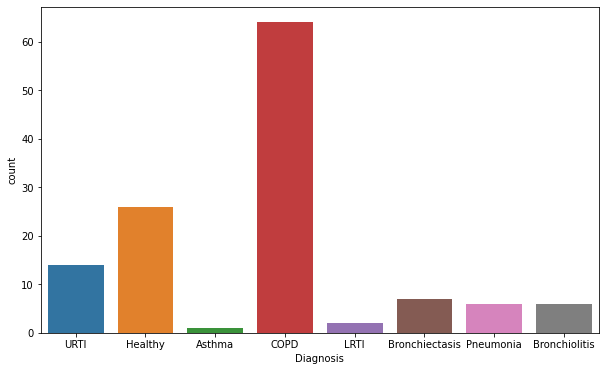

In [ ]:
'''Objective: understand the distribution of patient diagnosis'''
plt.figure(figsize=(10,6))
sns.countplot(x = diagnosis_df['Diagnosis']);

In [ ]:
'''Objective: merge the dataframes - diagnosis_df and data. Understand the distribution of diagnosis associated with respiratory cycle.'''
data = data.merge(diagnosis_df, on = 'Patient number')
data.head()

,start,end,crackles,wheezes,filename,Patient number,Diagnosis
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI


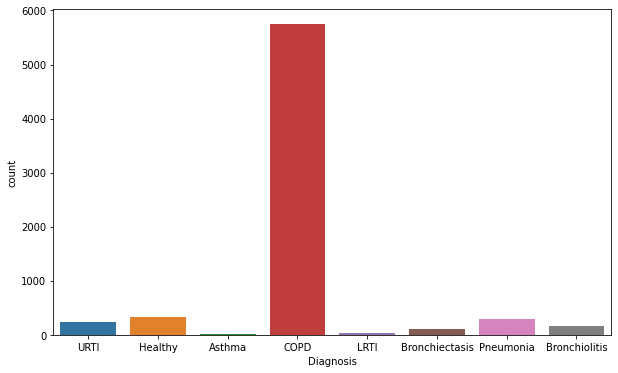

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x = data['Diagnosis']);

# Understand the data - distribution of normal/abnormal lung sound

In [ ]:
'''binary_sound_label : Normal lung sound = '0'; 
                        Any crackles/wheezes = '1' '''

'''multi_sound_label :  Normal lung sound = '0'; 
                        Only crackles = '1'; 
                        Only wheezes = '2', 
                        Both crackles and wheezes = '3' '''


def classification(df):
    for index, row in df.iterrows():
        if row['crackles'] + row['wheezes'] ==0:
            df.loc[index, 'binary_sound_label'] = 0
            df.loc[index, 'multi_sound_label'] = 0
        elif row['crackles'] > 0 and row['wheezes'] ==0:
            df.loc[index, 'binary_sound_label'] = 1
            df.loc[index, 'multi_sound_label'] = 1
        elif row['crackles'] == 0 and row['wheezes'] >0:
            df.loc[index, 'binary_sound_label'] = 1
            df.loc[index, 'multi_sound_label'] = 2
        else:
            df.loc[index, 'binary_sound_label'] = 1
            df.loc[index, 'multi_sound_label'] = 3

classification(data)

In [ ]:
data.head()

,start,end,crackles,wheezes,filename,Patient number,Diagnosis,binary_sound_label,multi_sound_label
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0


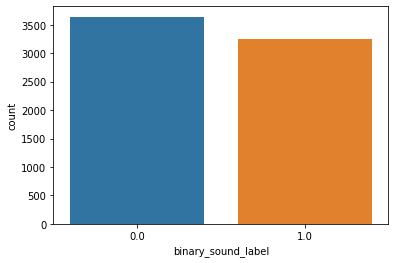

In [ ]:
sns.countplot(x = data['binary_sound_label']);

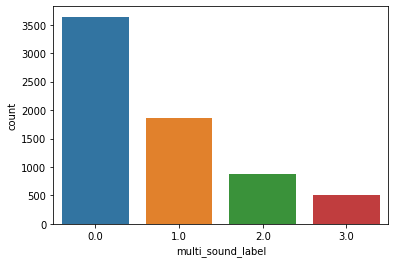

In [ ]:
sns.countplot(x = data['multi_sound_label']);